# The Story of Hollywood 

People have throughout history always look for ways to express themselves through art and since the invention of the Kinetograph, which was the first motion picture camera, by Thomas Edison and his British assistant William Dickson 1890 [1](https://www.pbs.org/wgbh/americanexperience/features/pickford-early-history-motion-pictures/#:~:text=In%201888%20in%20New%20York,a%20primitive%20motion%20picture%20camera.), motion pictures have become increasingly popular. In 2020 the box-office revenue in the US alone was USD $11.300.000$

Skriv noget mere

### Data
Almost everyone have a strong relationship to movies, the intrigue, enlighten, make you cry and make you laugh. We wanted to know more about the structure of the largest productions of them all, and that is why the project evolves around the [tmdb 5000](https://www.kaggle.com/tmdb/tmdb-movie-metadata) dataset. This dataset contains data on the plot, cast, crew, budget, and revenues of several thousand films, but have the advantage that the data is already filtered and cleaned. We choose this dataset as is provides a good foundation of our analysis, but other data sources will also in the report to verify and support the findings.


### Goal of the project
The overall idea of this project is to investigate interesting properties of Hollywood acting environment and how it has developed over time? As the dataset contains a lot of information, these properties have split into two major areas of focus. 
* Movies as a Voice of the times and the Evolution of Hollywood itself
* Hollywood as a closed community structue, with few Actors working alot together. Furthermore, that these communities also exsist outside the set of the movies

There are of course many more interesting elements to look at, kaggle suggests looking at "... the success of a movie before it is released?", or "Are there certain companies (Pixar?) that have found a consistent formula?", but our goal is that after having read this notebook, one would have gotten an in depth understanding of **hollywood as a voice of the times** and **the closed community structure of it**


NOTE: also that the reader experiance some beautifull plots 


## Basic stats of the Data and network

This section will present some basic information about the dataset and initial preperation to allow for the reader to get a good idea abouyt the data the project is working with

In [94]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime

### IMDB 5000

WHAT IS THE DATA ETC: WRITE MORE

In [22]:
# Datasets
RELATIVE_FILE_PATH='./'
movies = pd.read_csv(RELATIVE_FILE_PATH+'tmdb_5000_movies.csv')
credits = pd.read_csv(RELATIVE_FILE_PATH + 'tmdb_5000_credits.csv')

In [28]:
# Creating DF
df = movies.merge(right = credits, left_on = 'id', right_on = 'movie_id')

#Convert JSON to dict and extract the names of each actor in each movie
actors_per_movie = df['cast'].apply(lambda x: ','.join([y['name'] for y in json.loads(x)])).str.split(',', expand = True).fillna('')
actors_per_movie = df[['original_title', 'id']].merge(right = actors_per_movie, left_index = True, right_index = True)

#Unpivot
actors_per_movie = actors_per_movie.melt(id_vars=['original_title', 'id'])

#Remove empty rows
actors_per_movie = actors_per_movie[actors_per_movie['value'] != '']

#Number of movies per actor
pt = actors_per_movie.pivot_table(index = 'value', values='id', aggfunc = len).reset_index().sort_values(by='id', ascending = False).reset_index()

In [29]:
pt

index              value  id
0      45586  Samuel L. Jackson  67
1          2                Jr.  60
2      43599     Robert De Niro  57
3       6819       Bruce Willis  51
4      34677         Matt Damon  48
...      ...                ...  ..
54194  21075         Jack Foley   1
54195  21078        Jack Gargan   1
54196  21079        Jack George   1
54197  21082          Jack Ging   1
54198  54198                 徐帆   1

[54199 rows x 3 columns]

In [34]:
print(f"In the original {len(df)} movies, there are {len(pt)} actors. Of these actors {len(pt[pt['id']<5])} have starred in less than 5 movies")

In the original 4803 movies, there are 54199 actors. Of these actors 50394 have starred in less than 5 movies


#### Decreasing the size of the data

We now have the full dataset, but as we can see above there are quite Actors in this network that contribute very little information to the questions we want to answer. Modelling the network with actors as nodes and movies as the links between them we will have alot of low degree nodes potentially disturbing the picture.
Many of these low degree actors are most likely extras, but since there are only 4803 movies in the data and as of 2012 the United States has produced roughly 44.000 [movies](https://babelniche.com/2013/06/29/where-are-movies-made/) according to IMDB. 

Due to this, and also to reduce the complexity we have decided to only look at the top 500 most productive actors and actresses

In [35]:
#Select top N actors by number of movies
pt = pt.nlargest(500, 'id')
#Top N actors as Nodes
nodes = pt['value'].tolist()

#### The Network itself
As mentioned the network will consist of actors as nodes and movies as edges. Of course actors can participate in multiple movies together, and this is also part of our investigation. To handle this we will model the network as a weighted undirected graph where the weight is the number of movies the actors starred together in.

The network is also going to contain some other basic stats on nodes and edges:

**Edges**
* Weight
* Movie id list ( NOT IMPLEMENTED)

**Nodes**
* Name of actor/actress
* Movie id list
* Genre dictionary

The reason we only store the id's and not the full data is to reduce redundance and while not decreasing speed

In [83]:
# Creating the network

# Extracting genre
movie_genre={}
for x in movies.iterrows():
    movie_genre[x[1]['original_title']]=[y['name'] for y in json.loads(x[1]['genres'])]

    
#Create edges between actors that have been in the same movie
edges = []
actor_genre = {}
actor_movies_count = {}
actor_movies_list = {}
edge_movie_lookup = {}
for node in nodes:
    actor_movies = actors_per_movie[actors_per_movie['value'] == node]['original_title'].tolist()
    edges += [(node, x) for x in\
              actors_per_movie[(actors_per_movie['original_title'].isin(actor_movies)) \
                & (actors_per_movie['value'].isin(nodes))]['value'] if node != x]

    # Actor
    cnt=len(actor_movies)
    actor_movies_count[node] = cnt
    actor_movies_list[node] = actor_movies
    actor_genre[node]=[movie_genre[y] for y in actor_movies]


In [85]:
# Init graph
G = nx.Graph()

# Add nodes and edges
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [86]:
# Set attributes

ct=Counter(edges)
# Add weights
for key, value in ct.items():
    G.edges[key]['weight'] = value
    
# Generate list of movies for edges
for key, value in edge_movie_lookup.items():
    G.edges[key]['movies']=value

# Add most frequent genre
for actor in G.nodes:
    G.nodes[actor]['genre']=Counter([x for y in actor_genre[actor] for x in y])
    G.nodes[actor]['top_genre']=G.nodes[actor]['genre'].most_common(1)[0][0]
    G.nodes[actor]['top_genre']
    G.nodes[actor]['movies_count']=actor_movies_count[actor]
    G.nodes[actor]['movies']=actor_movies_list[actor]

In [91]:
# Taking a look at a node in the graph
print(actor)
for x in G.nodes[actor]:
    print (f"{x}:",G.nodes[actor][x])

Elisabeth Shue
genre: Counter({'Drama': 8, 'Comedy': 7, 'Thriller': 5, 'Romance': 4, 'Science Fiction': 4, 'Horror': 3, 'Adventure': 3, 'Family': 3, 'Action': 2, 'Mystery': 2, 'Crime': 1, 'Music': 1})
top_genre: Drama
movies_count: 17
movies: ['Piranha 3D', 'Molly', 'Hollow Man', 'The Saint', 'Don McKay', 'Leaving Las Vegas', 'Chasing Mavericks', 'House at the End of the Street', 'Back to the Future Part II', 'Dreamer: Inspired By a True Story', 'Hide and Seek', 'Back to the Future Part III', 'The Karate Kid', 'Deconstructing Harry', 'Gracie', 'Hamlet 2', 'Hope Springs']


### WIKIPEDIA YEAR LOOKUP

The second part of the dataset is a lookup of an the year/decades wikipedia page to see if the findings from our analysis corresponds to the sentiment found on the pages. The purpose and hypotesis of this is that we will find a direct correlation between the sentiment of movies and the sorrunding decands data.

One assumption here is that will let the production of hollywood reflect the general state of the world. The reason for this is that there is no pattern wikipedia pattern for year/decade lookup only for the us. Scraping multiple sites will take too much time and loose focus of the important stuff. A reason why this assumption might be allright is due to the fact that the earlies movies in the dataset start around 1970's, which means that society is quite globalised already

**Cleaning and preprocessing**
The data is fetched through the api and is parsed using regex to a raw but filtered state

The filtering applied is:
* Removing links an references to other pages identified by being within <> or {}
* Removing links identified by starting with url=
* Removing non alpha numeric charaters
* Removing links identified by starting with http

This leaves us some partly filtered data still containing stopwords etc. ready for analysis

In [162]:
#The content of the characters' wiki-pages is extracted using the wikipedia API
baseurl = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
title = 'titles='
content = 'prop=revisions&rvprop=content'
dataformat = 'format=json'

def look_up_decade(year: int)-> str:
    decade_start=int(year/10)*10
    query = '%s%s&%s&%s&%s' % (baseurl,action,f'titles={decade_start}s',content,dataformat)
    res = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))
    pages = res.get('query').get('pages')
    if not pages:
        raise Exception('No pages found')
    data = []
    for page in pages.keys():
        try:
            data.append(res['query']['pages'][page]['revisions'][0]['*'])
        except:
            print(f"Failed on pages{page}")
    return data

def process_data(d:list, limit=3)->list:
    data_string = ''
    temp_str = ''
    
    i=0
    for x in d:
        if i>=limit:
            break
        # Remove special chars and data in links
        temp_str=re.sub("[\{\<.*?[\}\>]", "", x)
        # Remove links
        temp_str=re.sub('url=.\S*','',temp_str)
        # Weird chars
        temp_str=re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str)
        # Remaning links
        temp_str=re.sub('http.\S*','',re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str))
        data_string += temp_str
        i+=1
    return data_string    

## Analysis of Network Evulution and Historical Reference

The overall idea here is to get an idea of how the network has evovled over time. To get an idea of this we will do the following
* Investigation of the netowrk in general to get at reference point of how the aggeragete networks should look
    * Links
    * In and out degree
    * Visualisation of the entire network with relevant attributes
    * Comparison with Random Networ
* Changes in structure over time
    * Degree distributions over time
    * Genre distribution over time
    * Particular patterns of actors work in genres
* Important words of the decades
    * TF-IDF
    * Relation to dominant genres
    * Wordclouds
* Sentiment of the decade
    * How does it relate to the TF-IDF
    * Does it reflect the major events of the us/world
        * Watergate of 1970s
        * Cold war of 1980s
        * Gulf war of 1990s
        * War on Terror 2000s
    * Most important words -> similarity with the decades wikipedia page
    

In [173]:
# ANALYSIS
print(f"Number of nodes in network: {G.number_of_nodes()}")
print(f"Number of links (edges) in network: {G.number_of_edges()}")
print(f"Average number of links per node: {round(G.number_of_edges()/G.number_of_nodes(),2)}")
print(f"Average shortes path: {round(nx.algorithms.average_shortest_path_length(G),4)}")

Number of nodes in network: 500
Number of links (edges) in network: 18218
Average number of links per node: 36.44
Average shortes path: 1.8567


In [170]:
in_degree = sorted([(d,n) for n, d in G.degree()], reverse=True)
print('Top 5 most connected characters')
in_degree[0:5]

Top 5 most connected characters


[(176, 'Samuel L. Jackson'),
 (148, 'Owen Wilson'),
 (142, 'John C. Reilly'),
 (141, 'Bruce Willis'),
 (140, 'Steve Buscemi')]

From the above we see that the network is very highly connected with ever node on average connecting to a 36.44 characters and an average shortest path only being 1.85. Relating this to the small world phenomenon known as six degrees of separation, which refeers to "two individuals, anywhere in the world, can be connected through a chain of six or fewer acquaintances"[\[1\]](http://networksciencebook.com/chapter/3#small-worlds), this network already by itself a community relating it to the larger population

From the data it looks like the actors are contributing to a very similiar amount of movies and that the network amongst the top 500 does not follow a **power law distribution** 

Lets take a look at this along with the productivity over time for the actors

In [174]:
degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

In [176]:
degree_sequence = sorted([d for n, d in degree], reverse=True)

In [177]:
hist, bin_edges = np.histogram(np.array(degree_sequence), bins=np.arange(degree[-1][1], degree[0][1]+2))

In [180]:
# For the barplot
degreeCount = Counter(degree_sequence) # Count the degrees
deg, cnt = zip(*degreeCount.items()) # deg: degree, cnt: the count of the degree


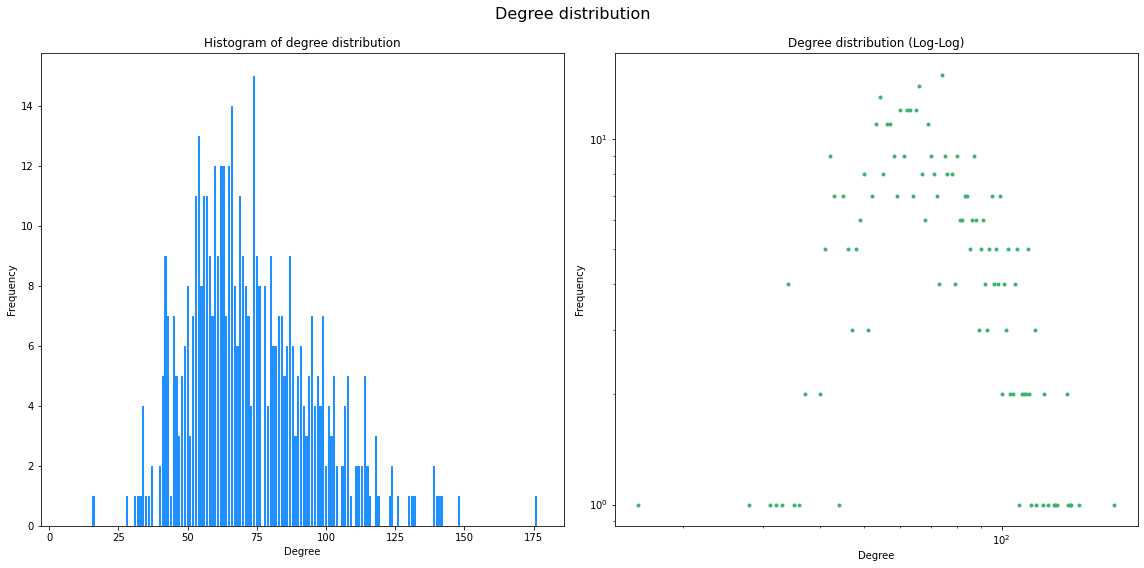

In [186]:
# Plot:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Degree distribution", fontsize=16)

axarr[0].bar(deg,cnt,color='dodgerblue')
axarr[0].set_xlabel('Degree')
axarr[0].set_ylabel("Frequency")
axarr[0].set_xlim([-3,max(deg)+10])
axarr[0].set_title("Histogram of degree distribution")

axarr[1].loglog(bin_edges[:-1],hist,'.', color="mediumseagreen")
axarr[1].set_xlabel('Degree')
axarr[1].set_ylabel("Frequency")
axarr[1].set_title("Degree distribution (Log-Log)")

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [242]:
# Reverse lookup for speed increase
reverse_movie_year_lookup={}
for row in df.iterrows():
    if pd.isna(row[1]['release_date']):
        continue
    reverse_movie_year_lookup[row[1]['original_title']]=datetime.strptime(row[1]['release_date'],'%Y-%m-%d')

#Extract data
relase_data = []
for node in G.nodes:
    actor_movies = sorted([reverse_movie_year_lookup[x].year for x in G.nodes[node]['movies']])
    first_release = min(actor_movies)
    actor_movies = [x-first_release for x in actor_movies]
    relase_data.append((node, actor_movies, [x for x in range(1,len(actor_movies)+1)]))
    
    

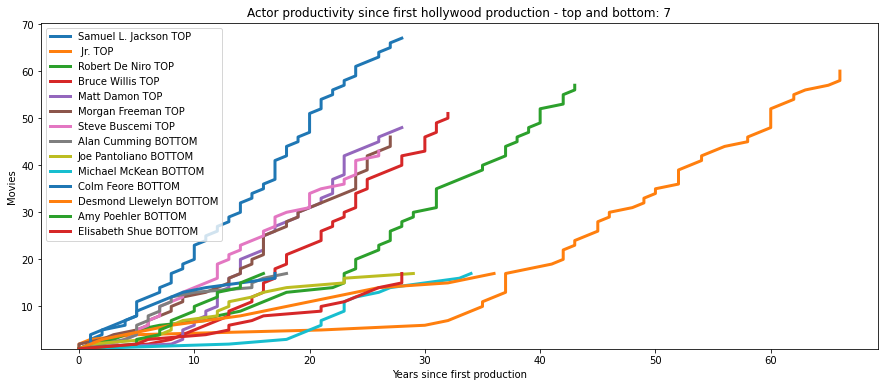

In [245]:
limit=7
l_relase_data=len(relase_data)
relase_data=sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[0:limit]+sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[l_relase_data-limit:l_relase_data]
fig, ax = plt.subplots(figsize=(15, 6))
for i in range(len(relase_data)):
    l_postfix=' TOP'
    if i>=limit:
        l_postfix=' BOTTOM'
    ax.plot(relase_data[i][1], relase_data[i][2], label=relase_data[i][0]+l_postfix,linewidth=3)
ax.set_ylim(1)
ax.set_ylabel('Movies')
ax.set_xlabel('Years since first production')
plt.title(f'Actor productivity since first hollywood production - top and bottom: {limit}')
plt.legend()
plt.show()

In [247]:
G.edges[('Samuel L. Jackson', 'Robert Downey Jr.')]

{'weight': 4}

This seems to validate our assumption of the network to not follow a powerlaw distribution. The data semmes normal distributed around 65 with a slight right skewness, though not completely. This would follow the intuition that a few actors a working on the majority of the feature films. The plot of actor productivity seems to tell a bit different story, that even between the top 500 Actors tgere are quite a big diffenrence in productivity between the top and bottom.

Relating this to the movies industry we also know that some actors can produce very large amount in a short time without great imdb scores where as others work on slower productions with a higher focus on production values

Lets take a look at visual representation of the network

In [249]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.6,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.7,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [ ]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

#Action
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Action'], node_size=[G.degree(y) for y in color_map['Action']], node_color='Red', label='Action')
#Adventure
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Adventure'], node_size=[G.degree(y) for y in color_map['Adventure']], node_color='Blue', label='Adventure')
#Animation
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Animation'], node_size=[G.degree(y) for y in color_map['Animation']], node_color='Pink', label='Animation')
#Comedy
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Comedy'], node_size=[G.degree(y) for y in color_map['Comedy']], node_color='Green', label='Comedy')
#Crime
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Crime'], node_size=[G.degree(y) for y in color_map['Crime']], node_color='Brown', label='Crime')
#Drama
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Drama'], node_size=[G.degree(y) for y in color_map['Drama']], node_color='Cyan', label='Drama')
#Family
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Family'], node_size=[G.degree(y) for y in color_map['Family']], node_color='Yellow', label='Family')
#Thriller
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Thriller'], node_size=[G.degree(y) for y in color_map['Thriller']], node_color='White', label='Thriller')
#Romance
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Romance'], node_size=[G.degree(y) for y in color_map['Romance']], node_color='Orange', label='Romance')
#Science Fiction
nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map['Science Fiction'], node_size=[G.degree(y) for y in color_map['Science Fiction']], node_color='Black', label='Science Fiction')

nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=0.09)
plt.legend(scatterpoints = 1)
nx.draw_networkx_labels(G, positions, font_size=4)
plt.rcParams["figure.figsize"] = [30,30]
plt.axis('off')
plt.title('Top 500 Actors \n Colored after most common genre, sized after total feature films')
plt.show()

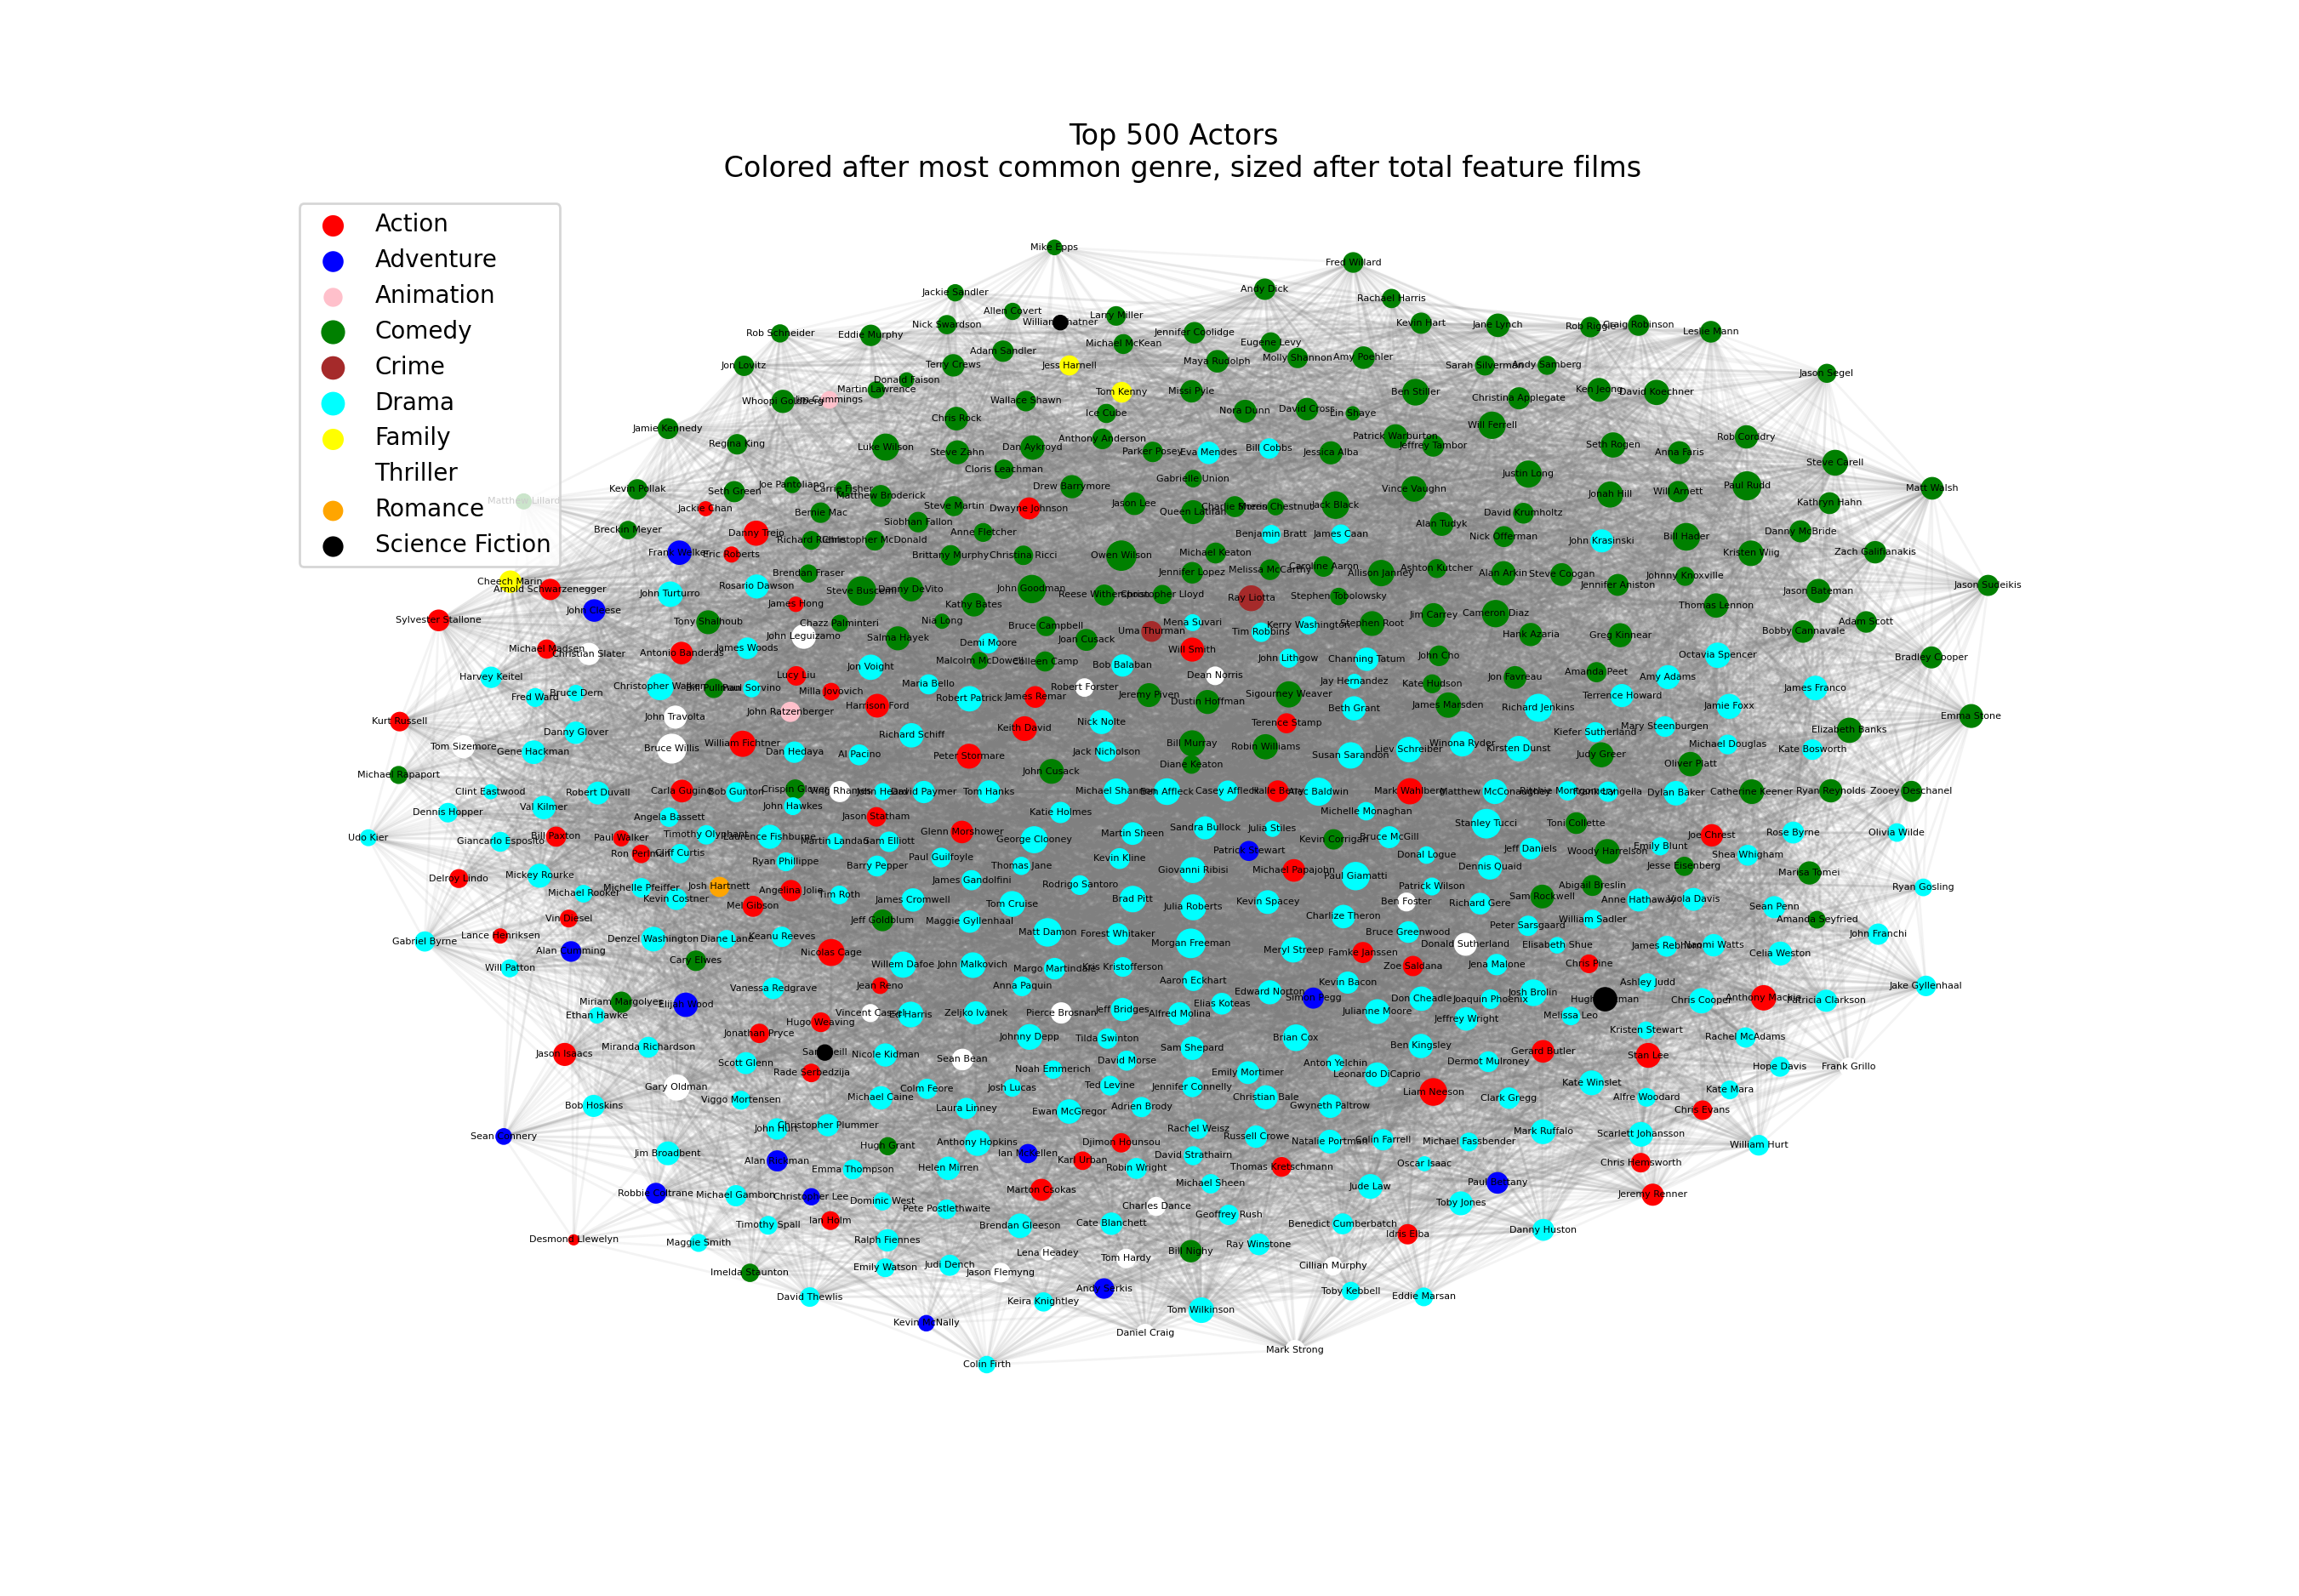

In [284]:
# Plot issues
Image(filename='Figure_1.png') 

From the above plot we see that there seem to be an overweight of actors acting within the genres of Comedy and Drama. 

DOES COMPARISON WITH RANDOM NETWORK WORK? WE ARE IN AN GC

### Changes in the netowrk over time

Introduction to this


## Analysis of Actor Communities and Their Sentiment

As presented in project assignment A, we have a hypotesis that there exist small communities within hollywood where groups of actors do the majority of their work together in specific genres. An example could be Denzel Washington which primarly does his work within Action and Drama. Does he always work with alot of the same crew?

To put it in general terms this section will uncover what actors work together, whether they form cliques? What charaterize these communites and a zoom in on specific Actors. 

This will be done through:
* Community detection
    * LIST DETECTION ALGORITHMS
* Important words
    * TF-IDF
    * Wordclouds
    * Lookup of movies
* Sentiment of communities
    * What communities are happy/sad?


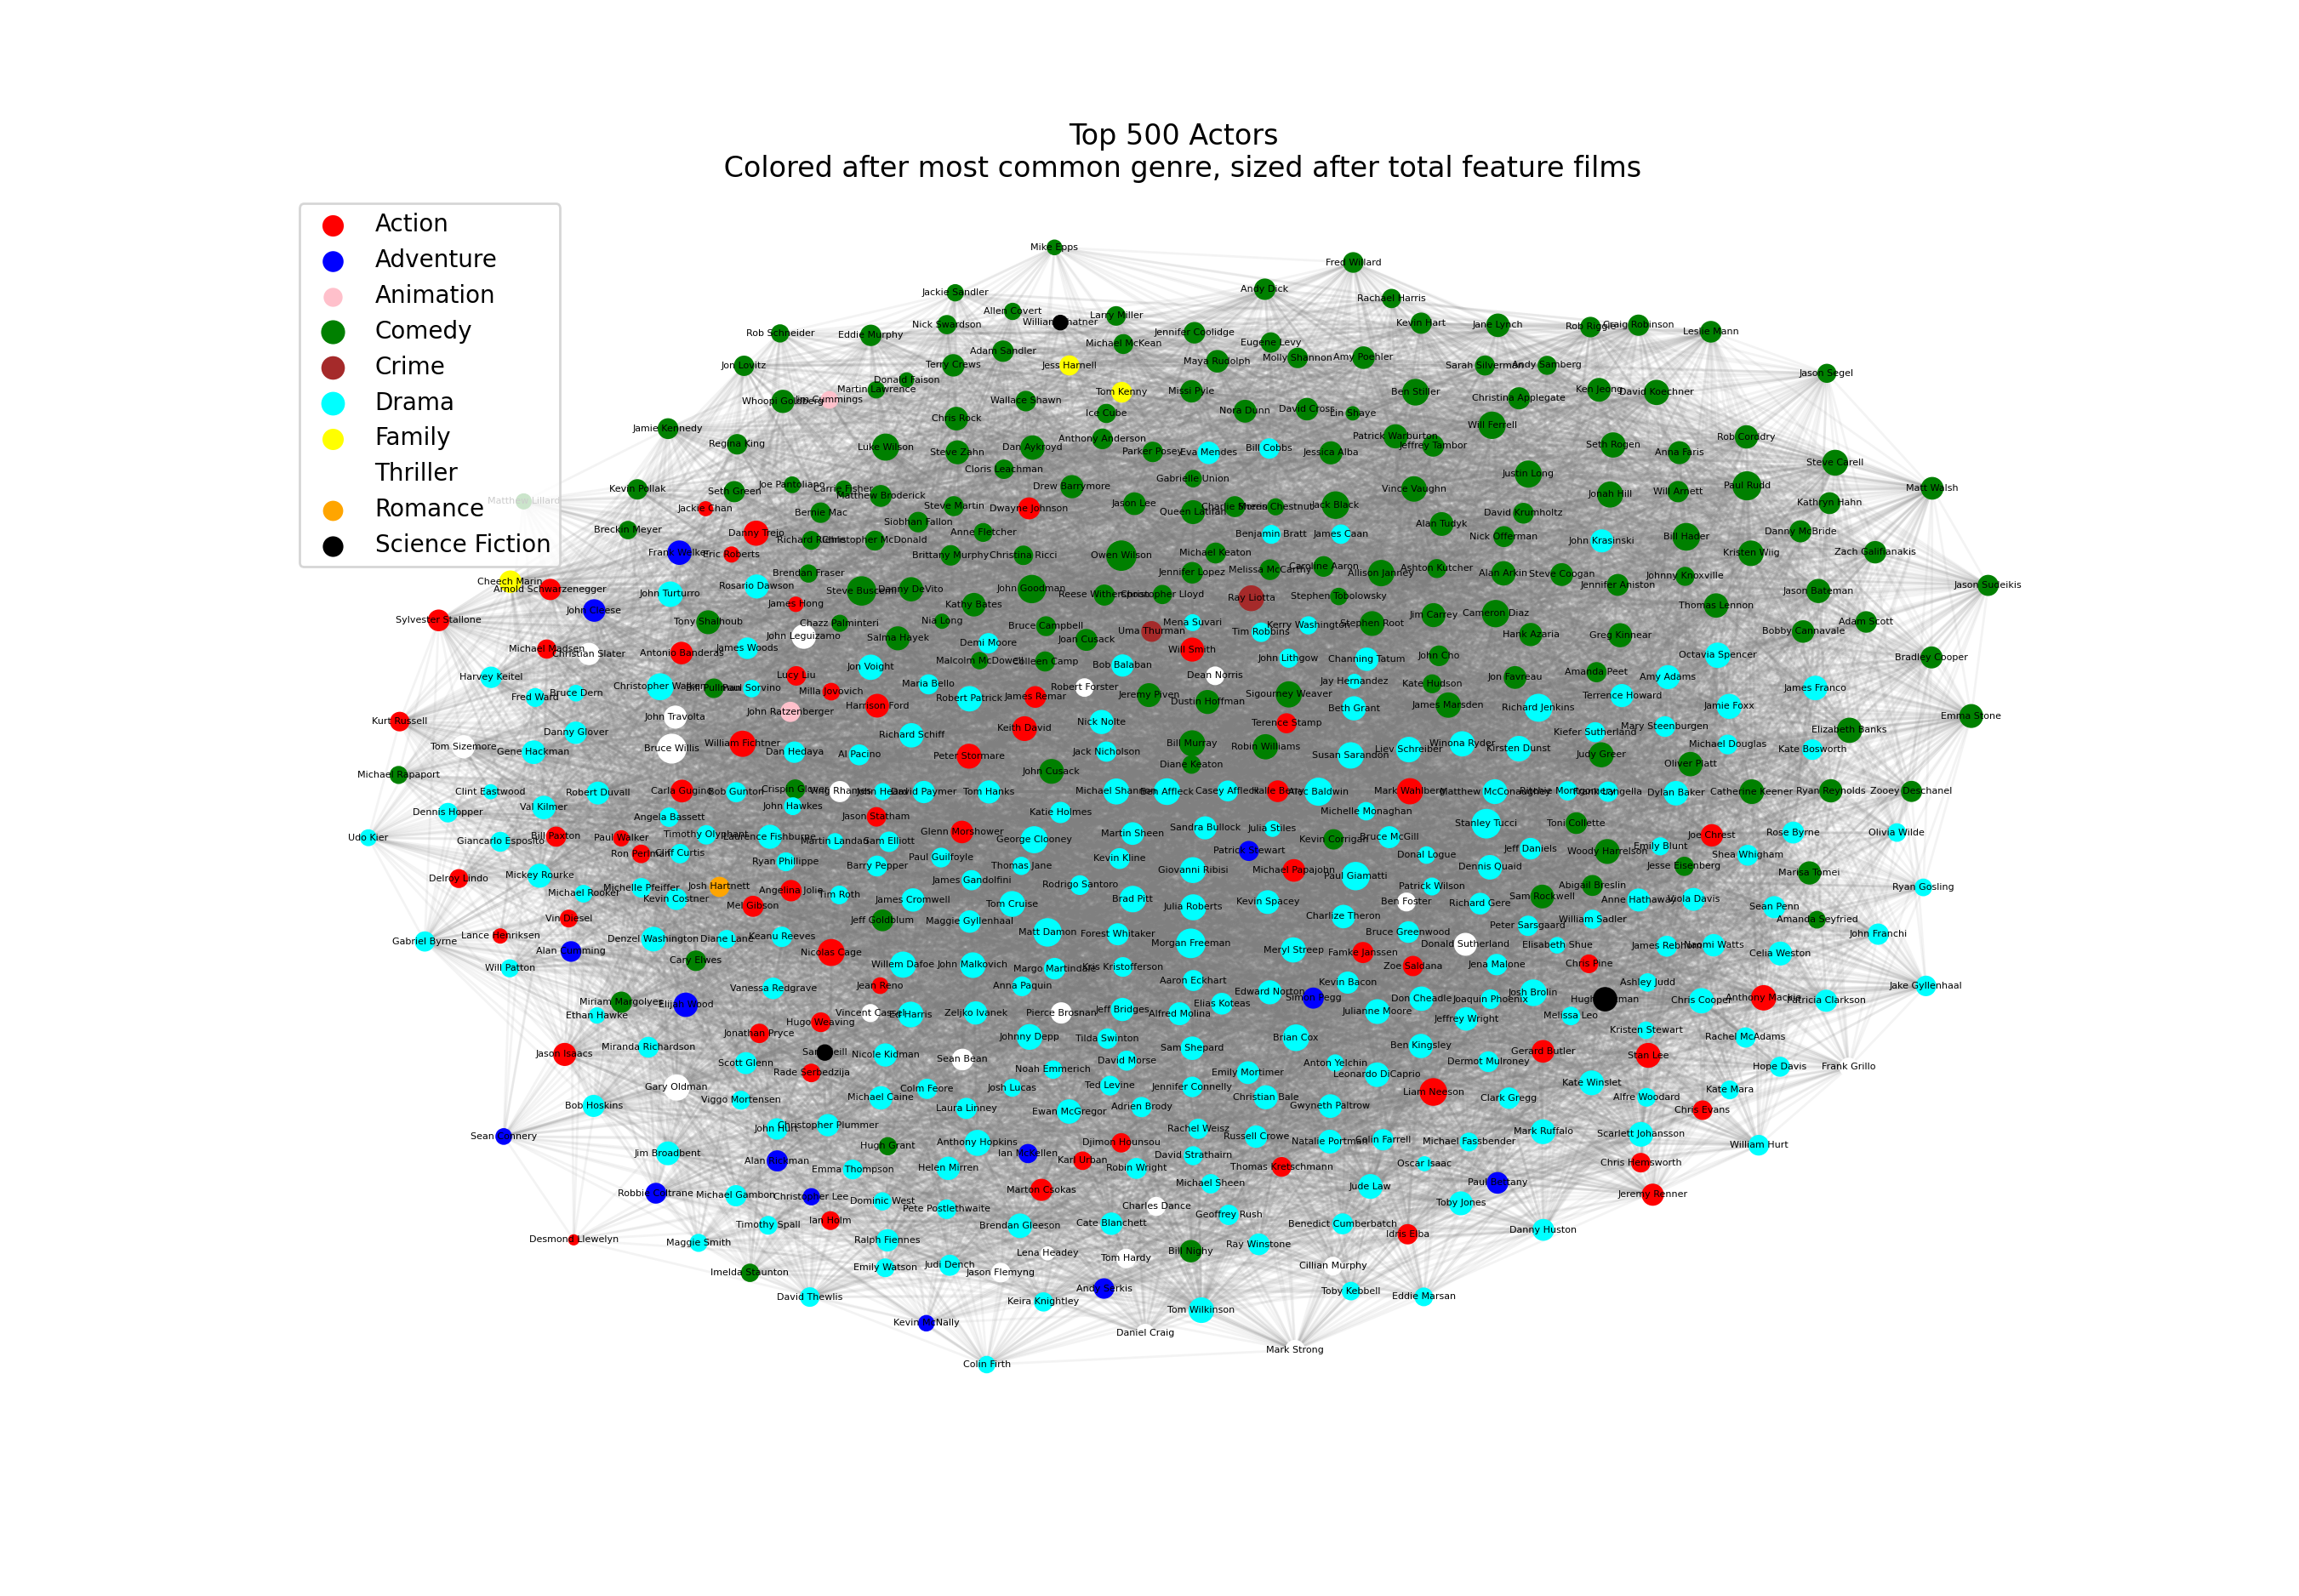

In [283]:
from IPython.display import Image
Image(filename='Figure_1.png') 

# Discussion of results

I should be noted here that we are working with a quite  small version of the network an